In [2]:
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import os
import yfinance as yf
from scipy import stats
from scipy.stats import norm, lognorm, t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
warnings.filterwarnings("ignore")

In [3]:
CPI=pd.read_excel('/Users/zackienzle/CBA/data/AUCPI Index.xlsx', header=5)
IOCR = pd.read_excel('/Users/zackienzle/CBA/data/RBACOR Index.xlsx', header=5)
GTAUD1YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD1YR Corp.xlsx', header=5)
GTAUD2YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD2YR Corp.xlsx', header=5)
GTAUD3YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD3YR Corp.xlsx', header=5)
GTAUD5YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD5YR Corp.xlsx', header=5)
GTAUD10YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD10YR Corp.xlsx', header=5)
GTAUD1YR

Date  PX_LAST  PX_BID
0    2025-05-12    3.555   3.570
1    2025-05-09    3.508   3.522
2    2025-05-08    3.471   3.485
3    2025-05-07    3.470   3.484
4    2025-05-06    3.517   3.533
...         ...      ...     ...
6624 1999-12-09    5.600   5.600
6625 1999-12-08    5.608   5.608
6626 1999-12-07    4.960   4.960
6627 1999-12-06    4.948   4.948
6628 1999-11-02    4.815   4.815

[6629 rows x 3 columns]

[*********************100%***********************]  2 of 2 completed

(2,)
['^AXPJ' '^AXJO']


Ticker        ^AXJO        ^AXPJ
count   2614.000000  2614.000000
mean       0.000214     0.000233
std        0.009677     0.013066
min       -0.096998    -0.148343
25%       -0.004314    -0.006293
50%        0.000777     0.000415
75%        0.005231     0.007327
max        0.070007     0.089406

Ticker         ^AXJO     ^AXPJ
Date                          
2015-01-05  0.002649  0.009080
2015-01-06 -0.015687 -0.011639
2015-01-07 -0.002088  0.013363
2015-01-08  0.005211  0.010879
2015-01-09  0.015628  0.008806
...              ...       ...
2025-05-05 -0.009735 -0.010354
2025-05-06 -0.000785  0.008137
2025-05-07  0.003300  0.007495
2025-05-08  0.001639  0.008069
2025-05-09  0.004822 -0.000284

[2614 rows x 2 columns]

Daily Prices Dashboard saved to plots/daily_prices_dashboard.html
Daily Returns Dashboard saved to plots/daily_returns_dashboard.html

Annualized Volatility:
Ticker
^AXJO    0.153622
^AXPJ    0.207422
dtype: float64


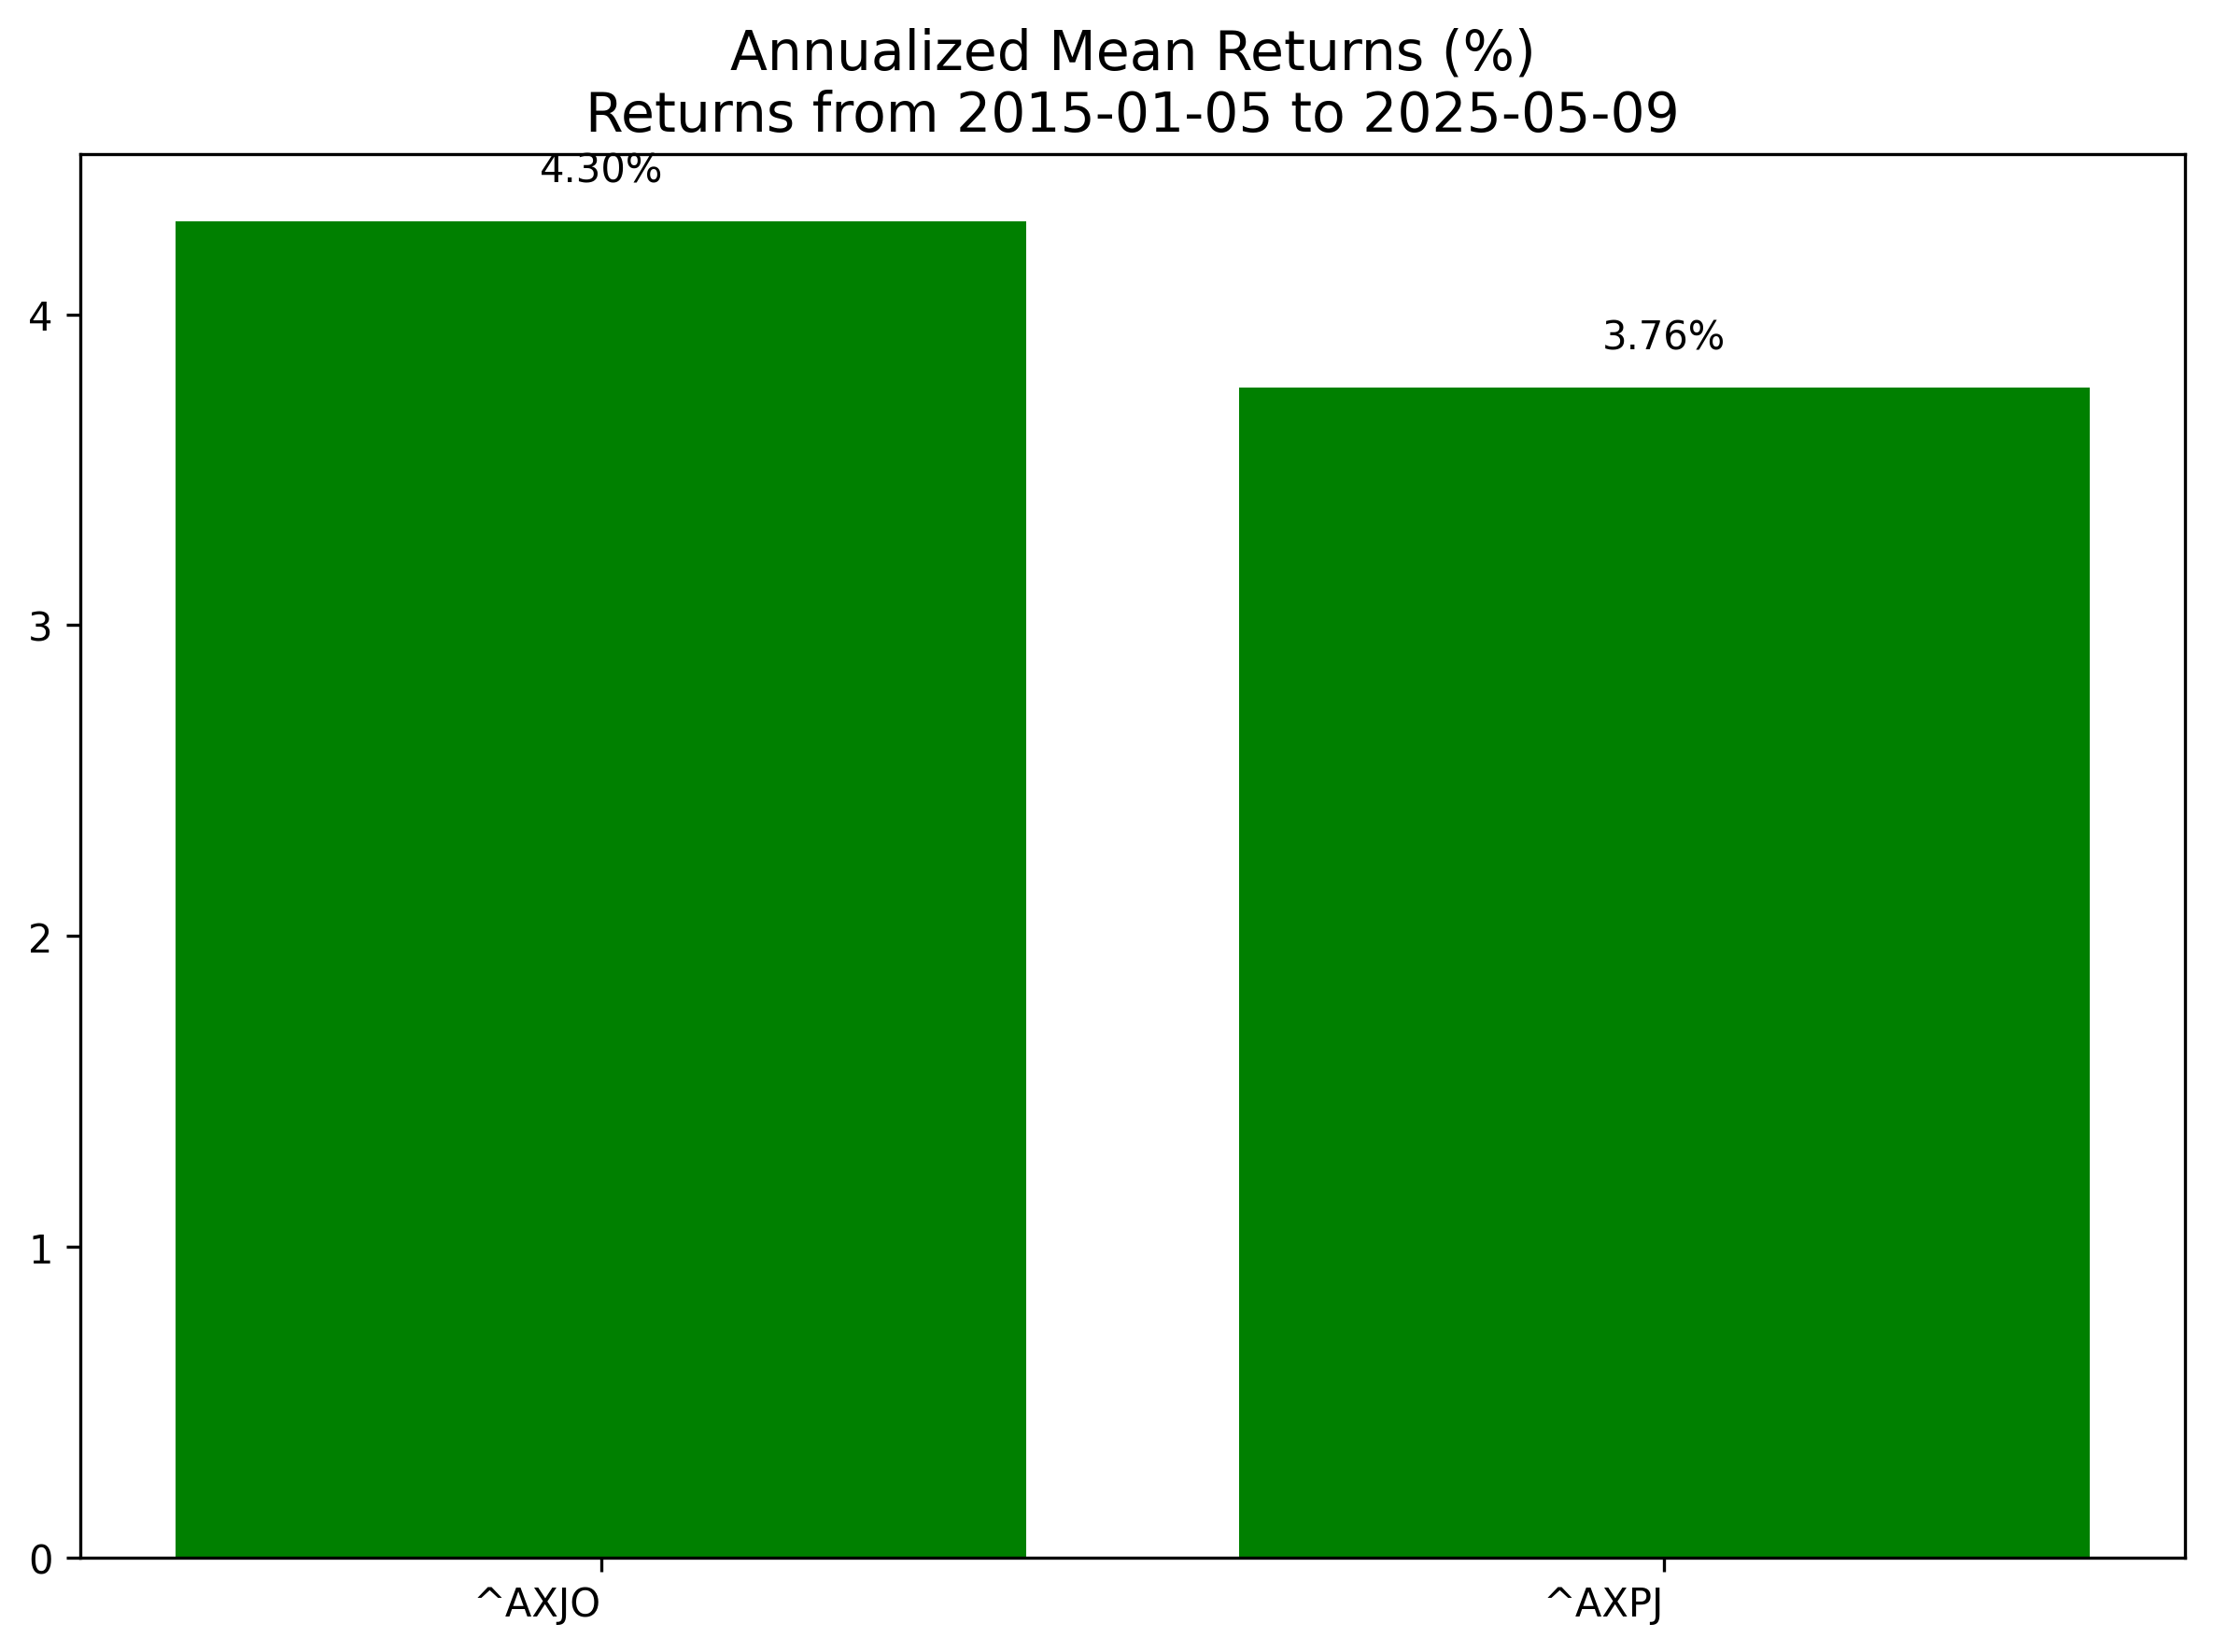


Annualized Mean Returns (%):
Ticker
^AXJO    4.300778
^AXPJ    3.763428
dtype: float64


<Figure size 640x480 with 0 Axes>

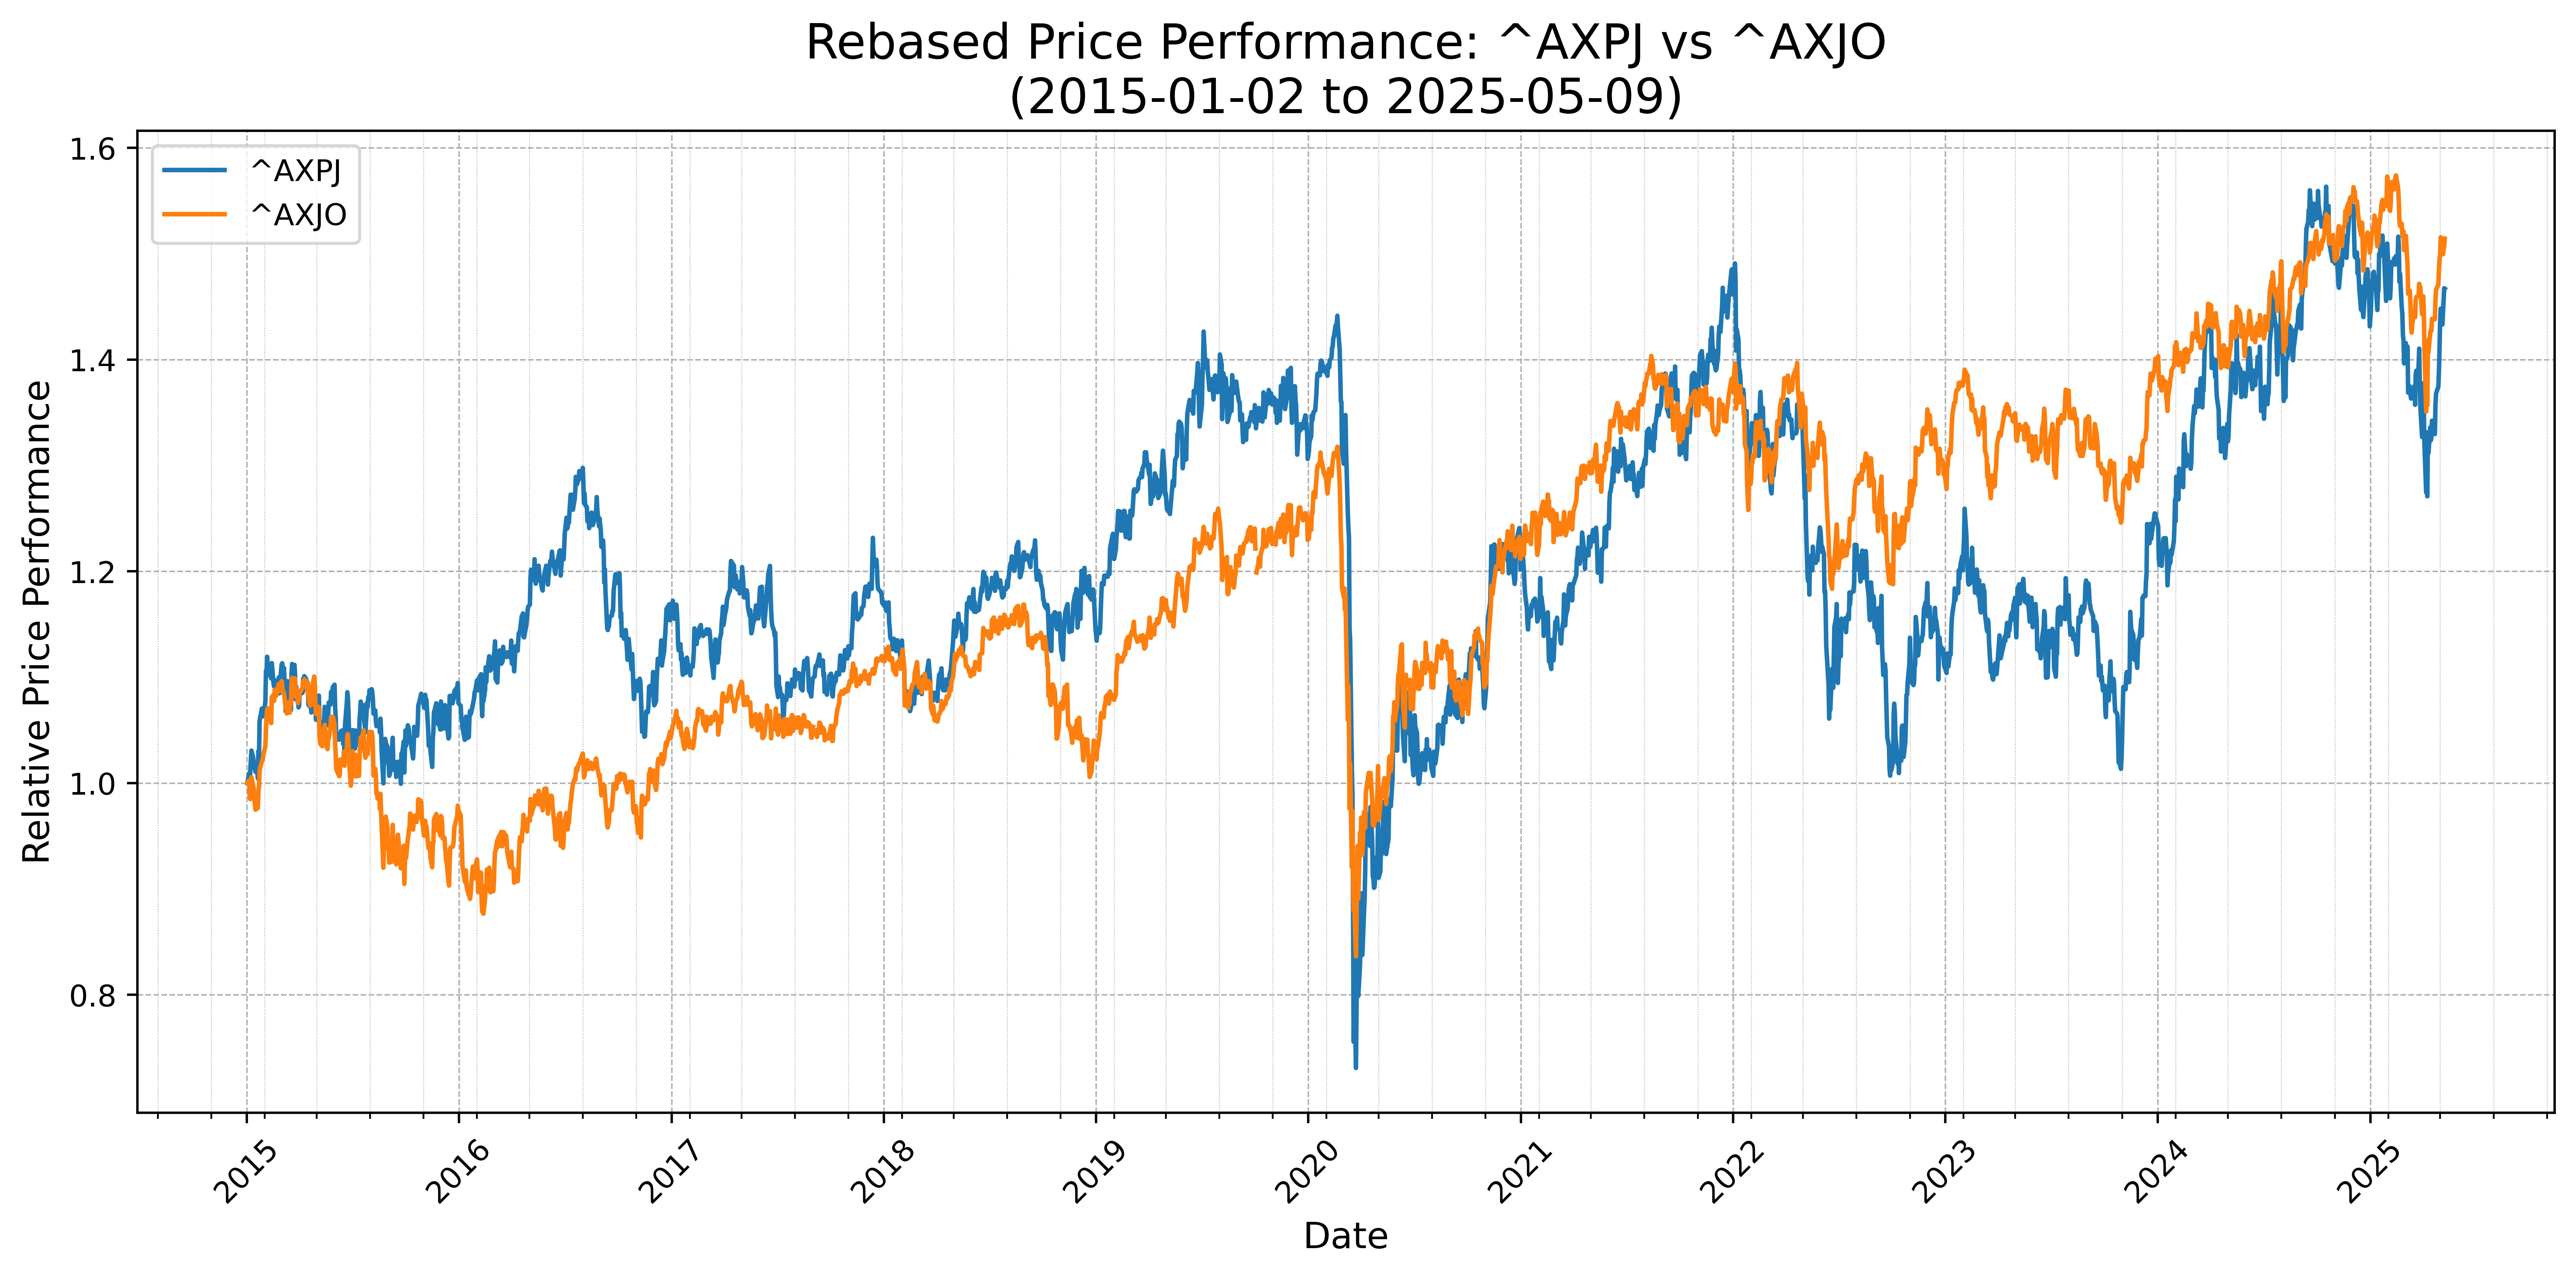

<Figure size 640x480 with 0 Axes>

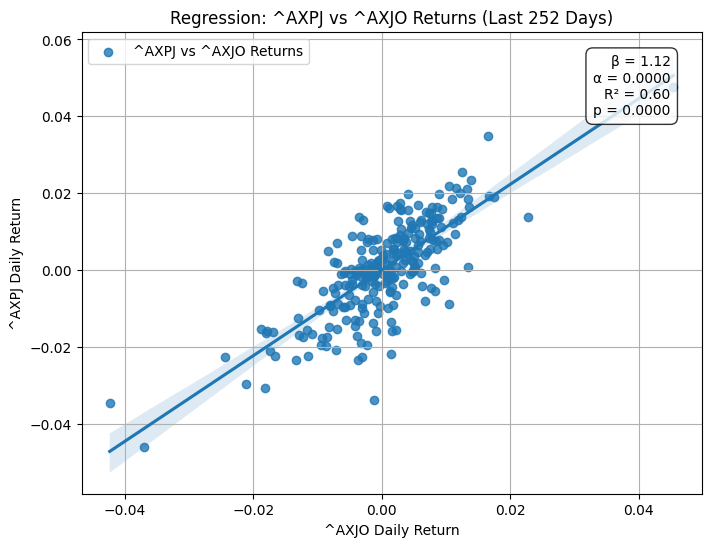


Beta Regression Results:
Beta: 1.1152
Alpha: 0.0000
R-value: 0.7739
P-value: 0.0000
Standard Error: 0.0577


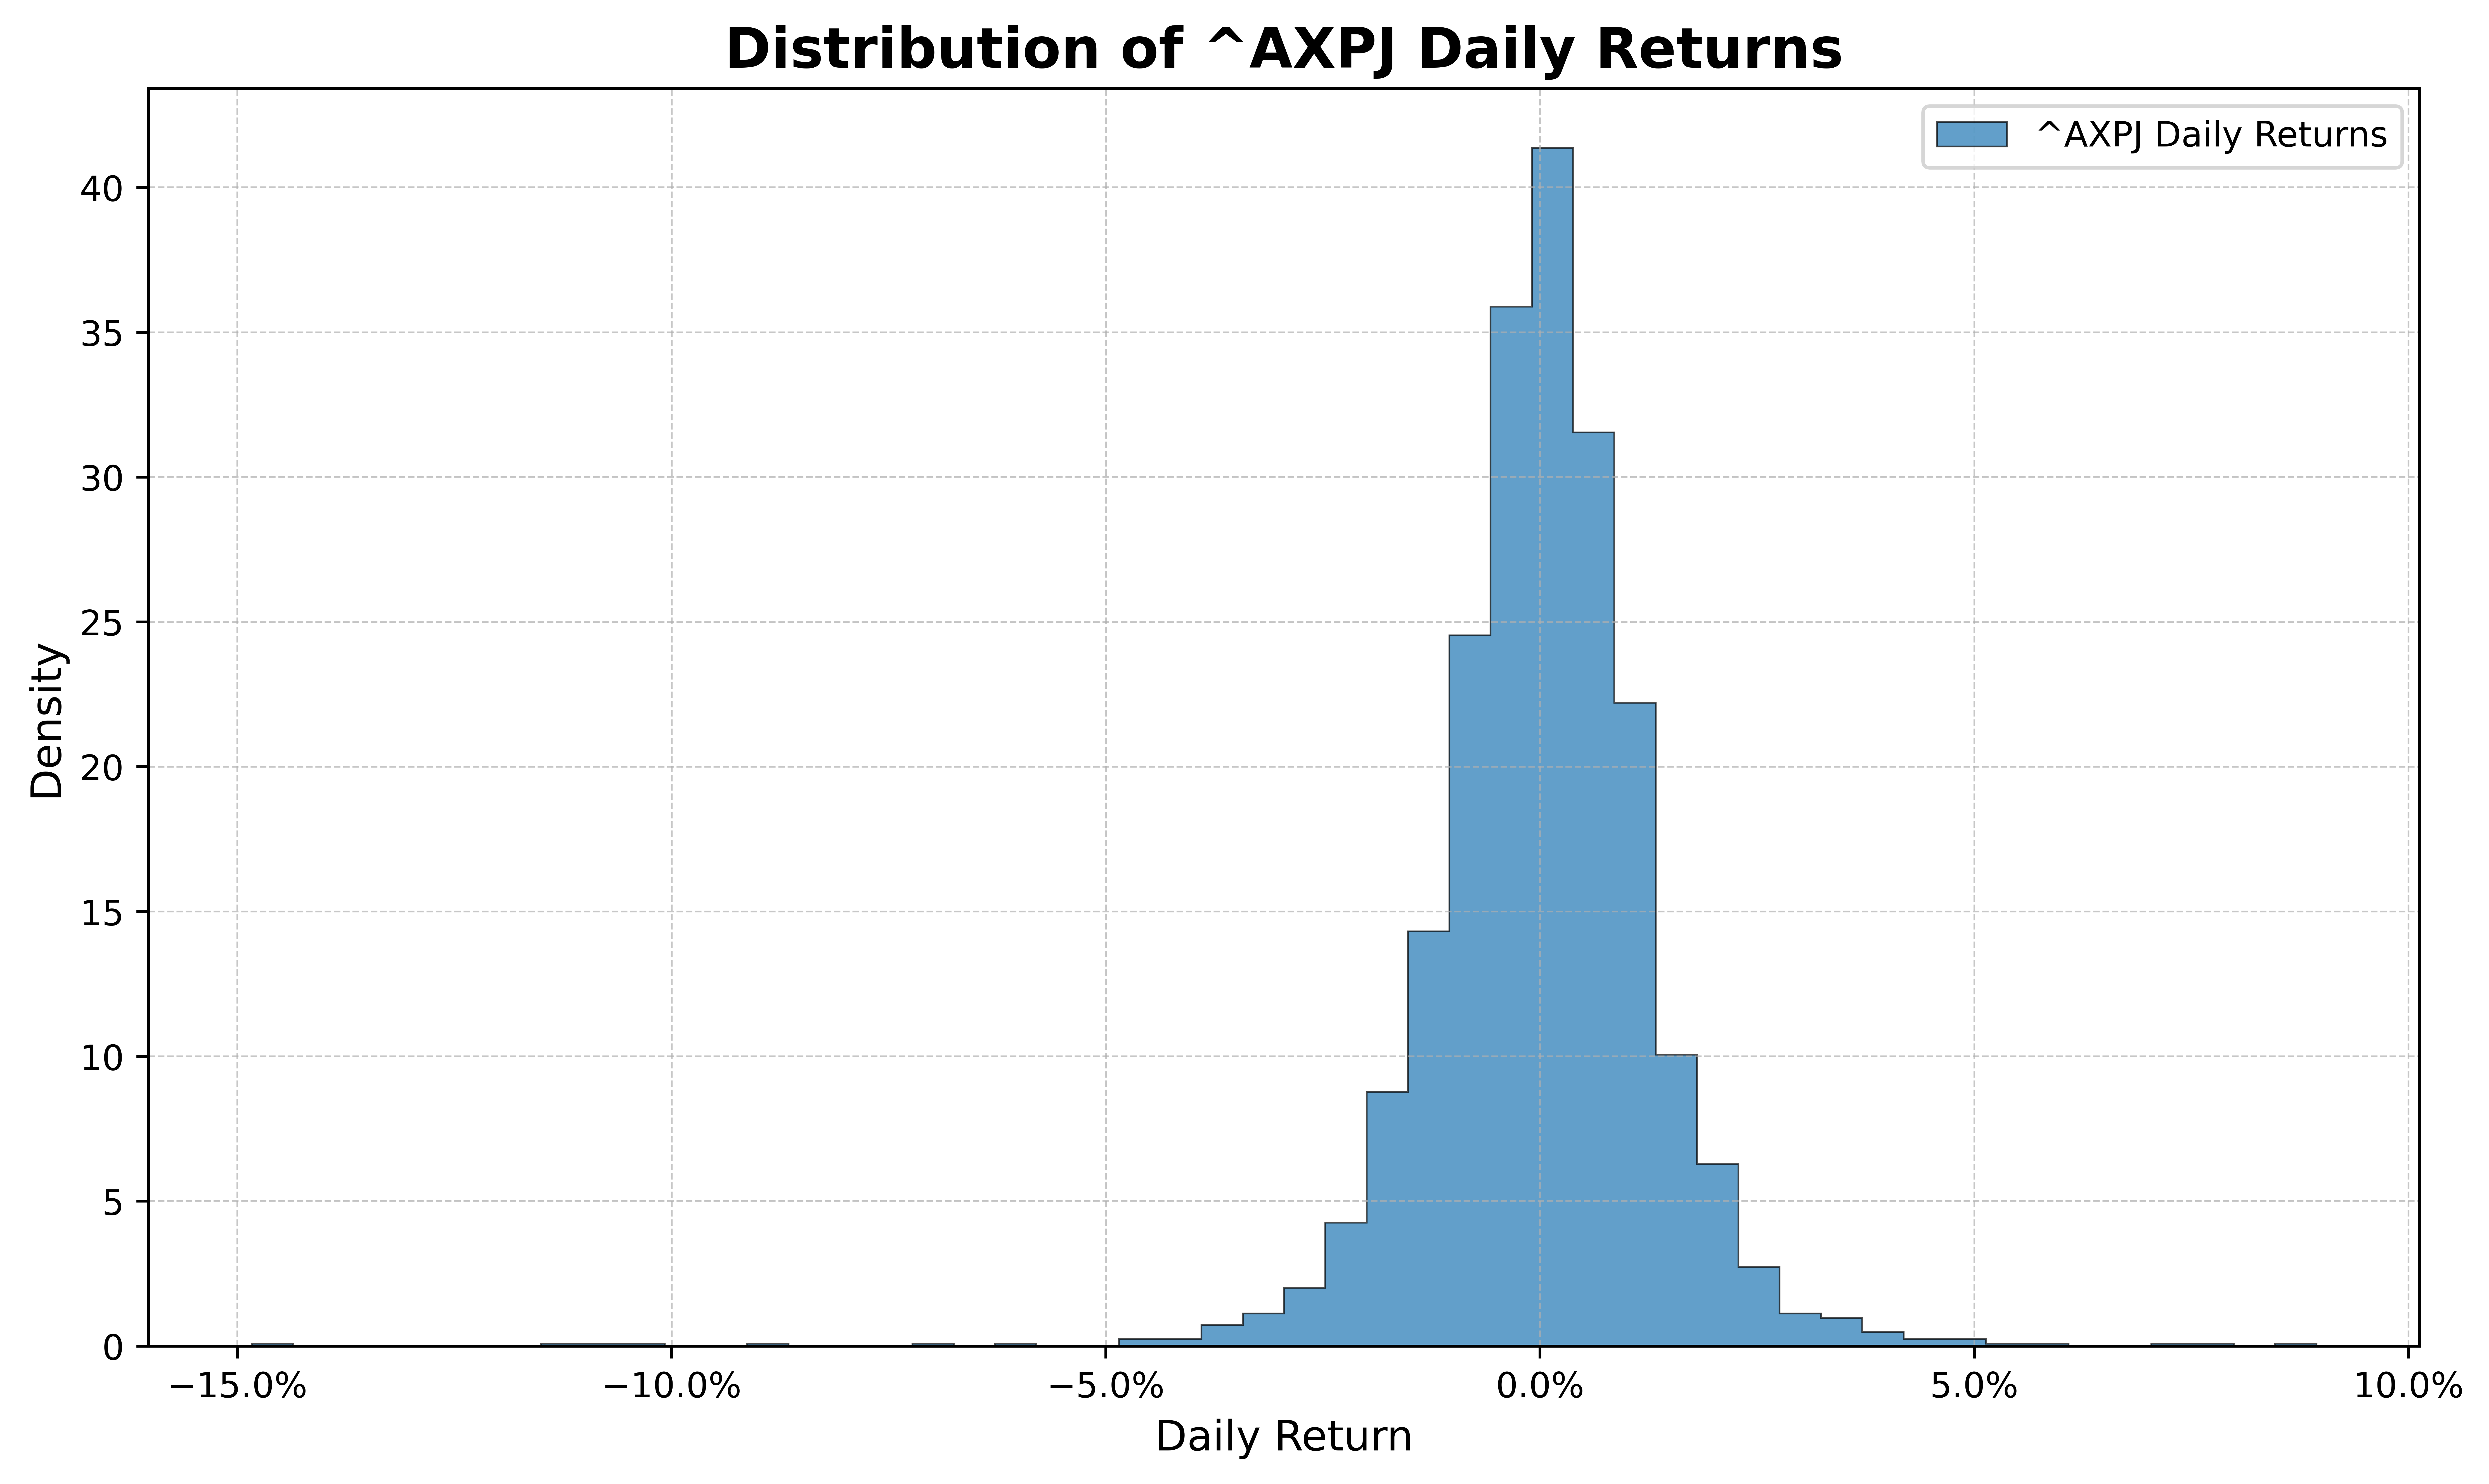

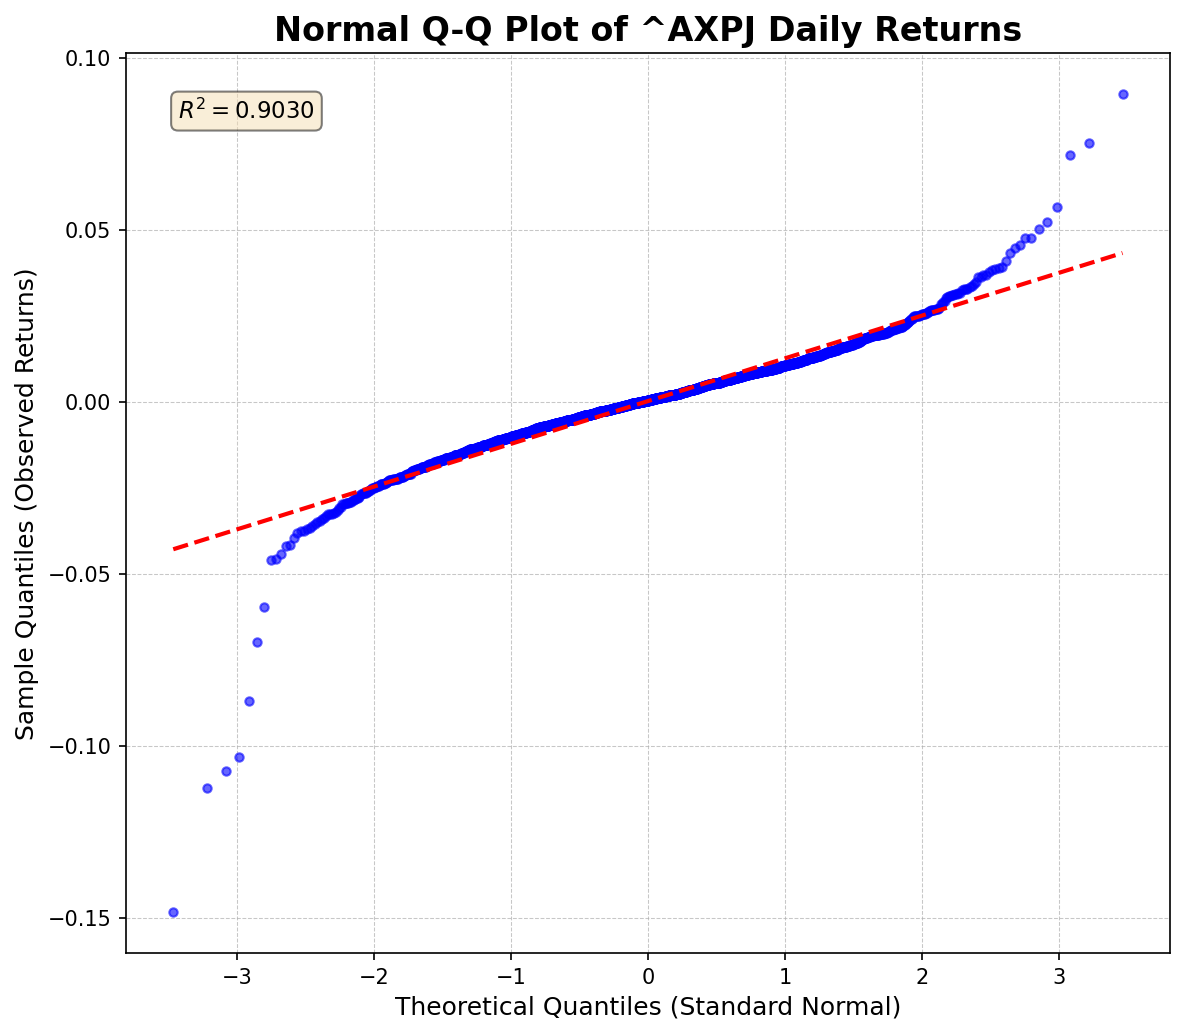

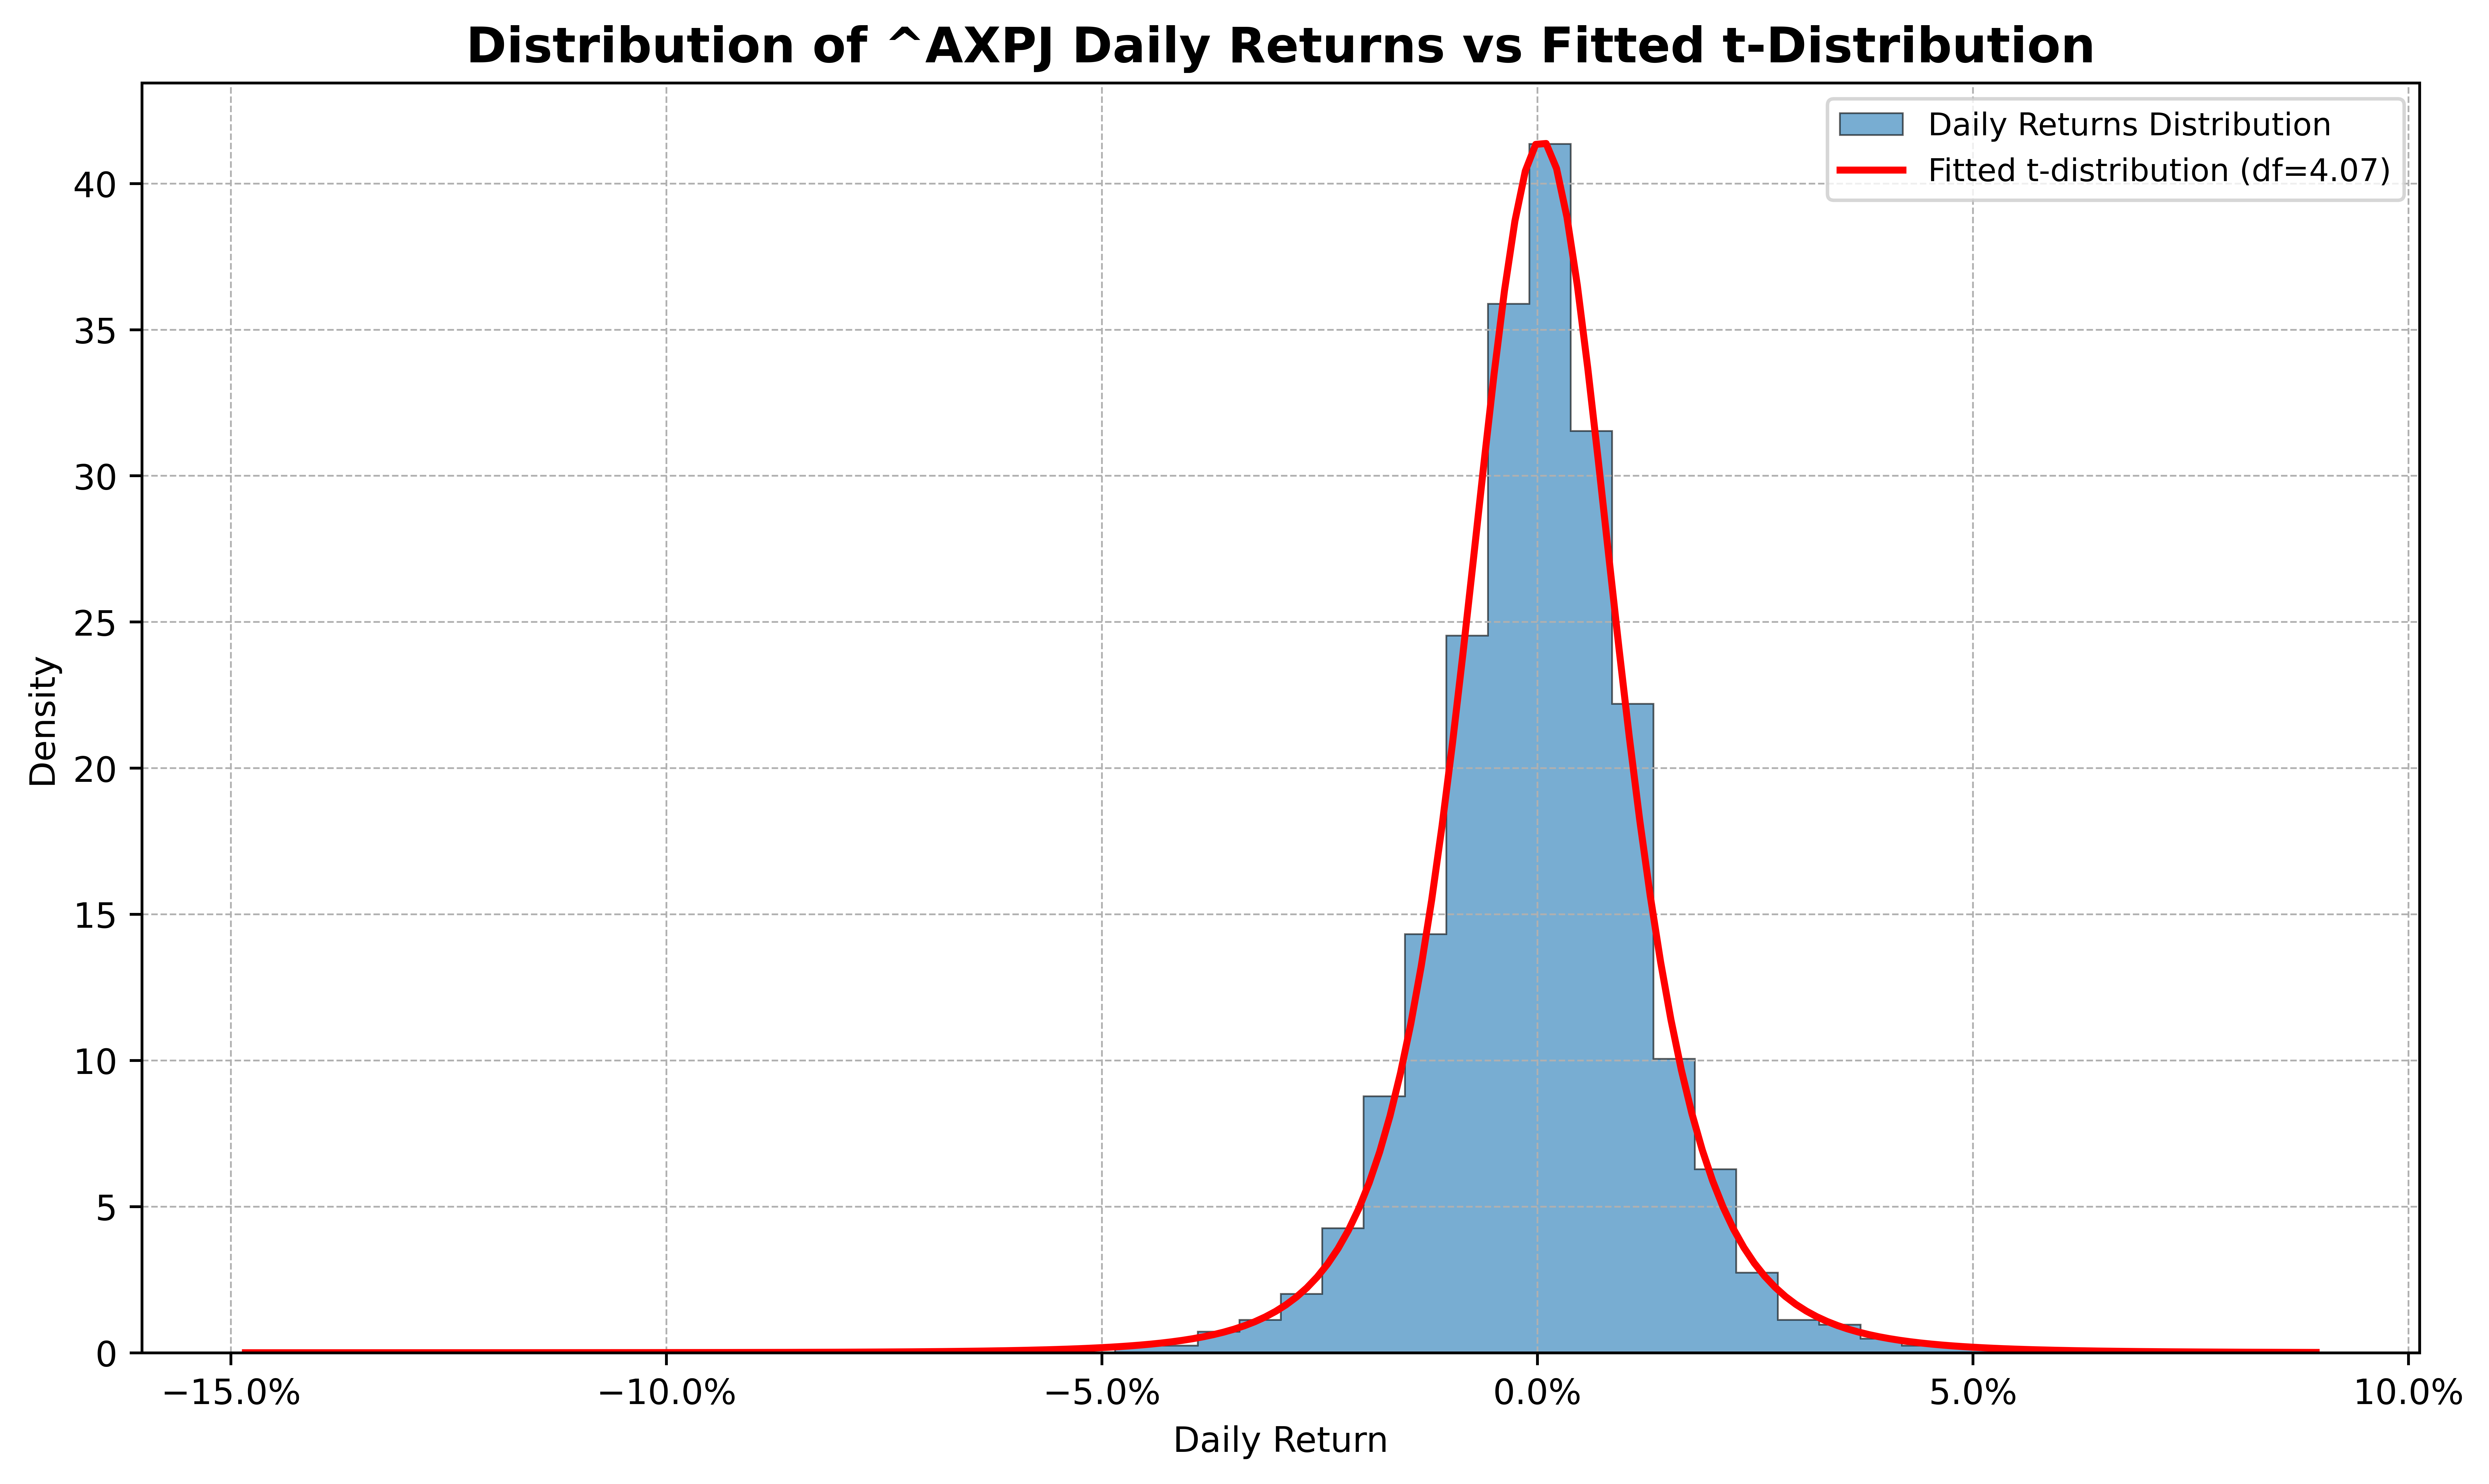

The one day 5% VaR for ^AXPJ (t-distribution fit) is -0.0188.

T-Distribution Fit Results:
Skewness: -1.0812
Kurtosis: 14.5369
Parametric VaR (5%) : -0.0188
Fitted df: 4.07
Fitted Mean: 0.0004
Fitted Sigma: 0.0091


In [4]:
# Define the stock tickers to analyze and the date range for data download.
FX: np.ndarray = np.array(["^AXPJ", "^AXJO"])
start_date: str = "2015-01-01"
end_date: str = "2025-5-12"
tickers: np.ndarray = np.concatenate(
    [FX],
    axis=0
)

# Define the directory to save generated plots.
plots_dir: str = "plots"

# Download historical market data once for all specified tickers.
# 'actions=True' includes dividends and stock splits.
# 'auto_adjust=False' keeps the original open, high, low, close, and adjusted close columns.
daily_prices: pd.DataFrame = yf.download(", ".join(tickers), start=start_date, end=end_date, actions=True, auto_adjust=False)

# Extract the adjusted closing prices. This is typically used for financial analysis as it accounts for corporate actions.
daily_closes: pd.DataFrame = daily_prices["Adj Close"].copy()

# Calculate the daily percentage change (returns) from the adjusted closing prices.
# 'dropna()' removes the first row which will contain NaN values after percentage change calculation.
daily_returns: pd.DataFrame = daily_closes.pct_change(fill_method=None).dropna()

print(tickers.shape)

print(tickers)

display(daily_returns.describe(include='all'))

display(daily_returns)

# Generates and saves interactive Plotly dashboard plots for daily prices and daily returns in separate files.
def dash_plot() -> None:
    """
    Generates and saves interactive Plotly dashboard plots for daily prices and daily returns
    as separate HTML files in the specified plots directory.
    """
    num_tickers: int = len(tickers)
    num_cols: int = 2
    # Calculate the number of rows needed for each section of plots (prices and returns) in their respective dashboards.
    num_rows_per_section: int = (num_tickers + num_cols - 1) // num_cols

    # Define titles for each subplot in the daily prices dashboard.
    subplot_titles_closes: list[str] = [f"{t} Close" for t in tickers]

    # Create a separate Plotly figure for the daily closes dashboard.
    fig_closes = make_subplots(rows=num_rows_per_section, cols=num_cols, subplot_titles=subplot_titles_closes)

    # Add a trace for each ticker's daily closing price to the closes dashboard.
    for i, ticker in enumerate(tickers):
        row = i // num_cols + 1
        col = i % num_cols + 1
        fig_closes.add_trace(
            go.Scatter(x=daily_closes.index, y=daily_closes.loc[:, ticker], name=f"{ticker} Close"),
            row=row,
            col=col,
        )

    # Update the layout for the daily closes dashboard.
    fig_closes.update_layout(height=300 * num_rows_per_section, autosize=True, title_text="Daily Prices Dashboard")

    # Define titles for each subplot in the daily returns dashboard.
    subplot_titles_returns: list[str] = [f"{t} Return" for t in tickers]

    # Create a separate Plotly figure for the daily returns dashboard.
    fig_returns = make_subplots(rows=num_rows_per_section, cols=num_cols, subplot_titles=subplot_titles_returns)

    # Add a trace for each ticker's daily return to the returns dashboard.
    for i, ticker in enumerate(tickers):
        row = i // num_cols + 1
        col = i % num_cols + 1
        fig_returns.add_trace(
            go.Scatter(x=daily_returns.index, y=daily_returns.loc[:, ticker], name=f"{ticker} Return"),
            row=row,
            col=col,
        )

    # Update the layout for the daily returns dashboard.
    fig_returns.update_layout(height=300 * num_rows_per_section, autosize=True, title_text="Daily Returns Dashboard")

    # Create the plots directory if it does not exist.
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Define file paths for saving the dashboard plots and save them as HTML files.
    plot_closes_filepath: str = os.path.join(plots_dir, "daily_prices_dashboard.html")
    fig_closes.write_html(plot_closes_filepath)
    print(f"Daily Prices Dashboard saved to {plot_closes_filepath}")

    plot_returns_filepath: str = os.path.join(plots_dir, "daily_returns_dashboard.html")
    fig_returns.write_html(plot_returns_filepath)
    print(f"Daily Returns Dashboard saved to {plot_returns_filepath}")

# Generate and save the dashboard plots.
dash_plot()

# Calculates the annualized volatility for the specified tickers using global daily returns.
def vol() -> pd.Series:
    """
    Calculates the annualized volatility for the specified tickers.

    Uses the standard deviation of daily returns, annualized assuming 252 trading days.
    """
    frequency: int = 252 # Assumes 252 trading days in a year.
    volatility: pd.Series = daily_returns.std() * np.sqrt(frequency)
    return volatility

# Calculate and print the annualized volatility.
volatility_results: pd.Series = vol()
print("\nAnnualized Volatility:")
print(volatility_results)

# Calculates and plots the annualized mean returns using global daily returns and saves the plot.
def annualized_mean_returns() -> pd.Series:
    """
    Calculates and plots the annualized mean returns for the specified tickers. 
    Uses the geometric mean of daily returns, annualized assuming 252 trading days.
    """
    # Compute the geometric average returns based on daily returns.
    # Annualized assuming 252 trading days.
    annualized_mean_returns: pd.Series = ((1 + daily_returns).prod() ** (
        252 / daily_returns.shape[0]
    ) - 1)

    # Convert returns to percentage for better readability in the plot.
    annualized_mean_returns = annualized_mean_returns * 100

    # Determine bar colors based on whether returns are positive or negative for visualization.
    conditional_colors: list[str] = ["green" if value > 0 else "red" for value in annualized_mean_returns]

    # Create a Matplotlib figure and axes for the bar plot.
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300);

    # Create the bar plot of annualized mean returns.
    bars = ax.bar(
        annualized_mean_returns.index,
        annualized_mean_returns,
        color=conditional_colors
    );

    # Add text labels above each bar showing the exact return percentage.
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1, # Add a small offset to position the text above/below the bar.
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', # Align text based on bar direction.
            fontsize=10
        );

    # Set the title and labels for the plot, using the date range from the daily returns index.
    title_text: str = f"Annualized Mean Returns (%)\nReturns from {daily_returns.index.min().strftime('%Y-%m-%d')} to {daily_returns.index.max().strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=0, ha='right');
    plt.tight_layout(); # Adjust layout to prevent labels overlapping.
    plt.show()

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, "annualized_mean_returns.png"), dpi=300, bbox_inches='tight')
    plt.close(fig) # Close the figure to free up memory.

    return annualized_mean_returns

# Calculate, plot, and print the annualized mean returns.
annualized_returns_results: pd.Series = annualized_mean_returns()
print("\nAnnualized Mean Returns (%):")
print(annualized_returns_results)

# Plots the rebased price performance using global daily closes and tickers, and saves the plot.
def price_plotting() -> None:
    """
    Plots the rebased price performance of the specified tickers.
    """
    # Rebase prices to the starting price (set the first data point for each ticker to 1).
    rebased_prices: pd.DataFrame = daily_closes / daily_closes.iloc[0]

    # Create a Matplotlib figure and axes for the line plot.
    fig, ax = plt.subplots(figsize=(12, 6), dpi=750)

    # Plot the rebased price performance for each ticker.
    for ticker in tickers:
        ax.plot(rebased_prices.index, rebased_prices[ticker], label=ticker)

    # Get the date range from the rebased prices index for the title.
    start_date_plot_str: str = rebased_prices.index.min().strftime('%Y-%m-%d')
    end_date_plot_str: str = rebased_prices.index.max().strftime('%Y-%m-%d')

    # Set the title, labels, and legend for the plot.
    ax.set_title(f'Rebased Price Performance: {" vs ".join(tickers)}\n({start_date_plot_str} to {end_date_plot_str})', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Relative Price Performance', fontsize=12)
    ax.legend(fontsize=10)

    # Configure date formatting and grid.
    ax.xaxis.set_major_locator(mdates.YearLocator()) # Set major ticks to yearly.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format major ticks as year.
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3)) # Set minor ticks to quarterly.
    plt.xticks(rotation=45) # Rotate x-axis labels for readability.
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

    plt.tight_layout(); # Adjust layout.
    plt.show()

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, f"{tickers[0]}_{tickers[1]}_Relative_Performance.png"), dpi=750, bbox_inches='tight')
    plt.close(fig) # Close the figure.

# Generate and save the rebased price performance plot.
price_plotting()

# Plots the daily closing prices of two tickers on a dual Y-axis using global data and saves the plot.
def dual_price_plotting() -> None:
    """
    Plots the daily closing prices of two tickers on a dual Y-axis for comparison.
    """
    # Create a Matplotlib figure and a primary axes.
    fig, ax1 = plt.subplots(figsize=(12, 6), dpi=900)
    # Create a secondary axes that shares the same x-axis for the second ticker's price.
    ax2 = ax1.twinx()

    # Plot the first ticker's closing price on the primary axes.
    line1 = ax1.plot(daily_closes.index, daily_closes[tickers[0]], color='tab:blue', label=tickers[0], linewidth=1.5)
    # Plot the second ticker's closing price on the secondary axes.
    line2 = ax2.plot(daily_closes.index, daily_closes[tickers[1]], color='tab:green', label=tickers[1], linewidth=1.5)

    # Set labels and tick parameters for both axes.
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel(f'{tickers[0]} Price', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.tick_params(axis='x', rotation=30)
    ax2.set_ylabel(f'{tickers[1]} Price', color='tab:green', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Combine the lines from both axes to create a single legend covering both tickers.
    lines_for_legend = line1 + line2

    # Set the title for the plot, using the date range from the daily closes index.
    plt.title(f'Comparison of {tickers[0]} and {tickers[1]} Stock Prices\n'
              f'({daily_closes.index.min():%Y-%m-%d} to {daily_closes.index.max():%Y-%m-%d})', fontsize=16)

    # Add the legend and configure x-axis date formatting and grid.
    ax1.legend(lines_for_legend, [l.get_label() for l in lines_for_legend], loc='upper left', fontsize=10)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

    fig.tight_layout(pad=1.5) # Adjust layout to prevent elements overlapping.
    plt.savefig(os.path.join(plots_dir, f"{tickers[0]}_{tickers[1]}_Dual_Price_Comparison.png"), dpi=900, bbox_inches='tight')
    plt.show()
    plt.close(fig) # Close the figure.

dual_price_plotting()

# Performs beta regression using global daily returns and tickers, and saves the plot.
def beta_regression() -> tuple[float, float, float, float, float]:
    """
    Performs a linear regression of the first ticker's daily returns against the second ticker's daily returns
    to calculate the market beta and alpha (intercept), and visualizes the regression.

    Uses the last 252 trading days of data for the regression.
    The regression results (beta, alpha, R-squared, p-value) are displayed in the plot legend.
    """
        # Extract the daily returns for the instrument and the market index, and slice to the last 252 trading days.
    # This period is commonly used for beta calculations.
    instrument_returns_sliced: pd.Series = daily_returns[tickers[0]].iloc[-252:]
    index_returns_sliced: pd.Series = daily_returns[tickers[1]].iloc[-252:]

    # Perform the linear regression using SciPy's linregress function.
    beta, alpha, r_value, p_value, std_err = stats.linregress(index_returns_sliced.values, instrument_returns_sliced.values)

    # Create a Matplotlib figure and axes for the regression plot.
    plt.figure(figsize=(8, 6))

    # Create a regression plot using Seaborn, which also plots the fitted line and scatter points.
    # Set label for the scatter points if a legend is desired for them, otherwise remove label.
    ax = sns.regplot(x=index_returns_sliced.values, y=instrument_returns_sliced.values, label=f'{tickers[0]} vs {tickers[1]} Returns')


    # Create the annotation string with regression results.
    # Using newline characters to separate the metrics across multiple lines for readability.
    annotation_text: str = (
        f'β = {beta:.2f}\n'
        f'α = {alpha:.4f}\n' # Alpha often small, show more decimals
        f'R² = {r_value**2:.2f}\n'
        f'p = {p_value:.4f}' # p-value often small, show more decimals
    )

    # Add the annotation text directly to the plot.
    ax.text(0.95, 0.95, annotation_text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)) # Changed box color and alpha

    # Set the title and labels for the plot, indicating the tickers and the data period used for the regression.
    plt.title(f'Regression: {tickers[0]} vs {tickers[1]} Returns (Last {len(instrument_returns_sliced)} Days)')
    plt.xlabel(f'{tickers[1]} Daily Return')
    plt.ylabel(f'{tickers[0]} Daily Return')
    plt.grid(True) # Add a grid for better readability.
    ax.legend(loc='best')

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, f"{tickers[0]}_{tickers[1]}_Beta_Regression.png"), dpi=900, bbox_inches='tight')
    plt.show()

    return beta, alpha, r_value, p_value, std_err

# Perform beta regression and print the results.
beta_results: tuple[float, float, float, float, float] = beta_regression()
print("\nBeta Regression Results:")
print(f"Beta: {beta_results[0]:.4f}")
print(f"Alpha: {beta_results[1]:.4f}")
print(f"R-value: {beta_results[2]:.4f}")
print(f"P-value: {beta_results[3]:.4f}")
print(f"Standard Error: {beta_results[4]:.4f}")

# Plots and saves a histogram of a ticker's daily returns distribution
def plot_histogram(returns_series: pd.Series, ticker_name: str, bins: int = 50) -> None:
    """
    Provides a visual representation of the frequency distribution of returns.
    """
    # Create a Matplotlib figure and axes for the histogram.
    fig, ax = plt.subplots(figsize=(10, 6), dpi=900)

    # Create the histogram. 'density=True' normalizes the histogram so the area integrates to 1.
    ax.hist(returns_series, bins=bins, density=True, histtype='stepfilled',
            alpha=0.7, label=f'{ticker_name} Daily Returns', edgecolor='black', linewidth=0.5)

    # Set the title, labels, and format the x-axis as percentages for clarity.
    ax.set_title(f"Distribution of {ticker_name} Daily Returns", fontsize=16, weight='bold')
    ax.set_xlabel("Daily Return", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7) # Add a grid.
    ax.legend(fontsize=10) # Add a legend.

    fig.tight_layout() # Adjust layout.

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, f"{ticker_name}_returns_histogram.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig) # Close the figure to free up memory.

plot_histogram(daily_returns[tickers[0]], tickers[0], bins=50)

# Plots and saves a Quantile-Quantile (Q-Q) plot using global plots_dir.
def plot_qq(returns_series: pd.Series, ticker_name: str) -> None:
    """
    Plots and saves a Quantile-Quantile (Q-Q) plot to visually assess if returns follow a normal distribution.
    Compares the quantiles of the observed returns data against the theoretical quantiles of a normal distribution.
    """
    # Create a Matplotlib figure and axes for the Q-Q plot.
    fig, ax = plt.subplots(figsize=(8, 7), dpi=150)

    # Generate the Q-Q plot using SciPy's probplot function against a standard normal distribution.
    (osm, osr), (slope, intercept, r) = stats.probplot(returns_series,
                                                      dist=stats.norm,
                                                      plot=ax)

    # Get plot elements to customize their appearance.
    line_elements = ax.get_lines()
    scatter_points = line_elements[0] # These are the points representing the sample quantiles.
    fit_line = line_elements[1] # This is the theoretical quantile line (for normal distribution).

    # Customize the appearance of the scatter points.
    scatter_points.set_markerfacecolor('blue')
    scatter_points.set_markeredgecolor('blue')
    scatter_points.set_markersize(4)
    scatter_points.set_alpha(0.6)

    # Customize the appearance of the fit line.
    fit_line.set_color('red')
    fit_line.set_linewidth(2)
    fit_line.set_linestyle('--')

    # Set the title and labels for the plot.
    ax.set_title(f"Normal Q-Q Plot of {ticker_name} Daily Returns", fontsize=16, weight='bold')
    ax.set_xlabel("Theoretical Quantiles (Standard Normal)", fontsize=12)
    ax.set_ylabel("Sample Quantiles (Observed Returns)", fontsize=12)

    # Compute and display the R-squared value, indicating how well the data fits the normal distribution.
    r_squared: float = r**2
    ax.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$',
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7) # Add a grid.

    fig.tight_layout() # Adjust layout.

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, f"{ticker_name}_qq_plot.png"), dpi=900)
    plt.show()
    plt.close(fig) # Close the figure.

plot_qq(daily_returns[tickers[0]], tickers[0])

# Plots a histogram of returns, fits a Student's t-distribution and computes VaR.
def plot_t_dist_histogram(returns_series: pd.Series, ticker_name: str, bins: int = 50, var_quantile: float = 0.05) -> tuple[float, float, float, float, float, float, float]:
    """
    Plots a histogram of a ticker's daily returns distribution and fits a Student's t-distribution to the data.
    Provides a visual comparison between the empirical distribution of returns and the fitted t-distribution.
    Computes and prints the parametric Value-at-Risk (VaR) based on the fitted t-distribution.
    """
    # Fit a Student's t-distribution to the returns data using maximum likelihood estimation.
    # 'loc' and 'scale' are the mean and standard deviation of the distribution.
    tdf, tmean, tsigma = stats.t.fit(returns_series)
    # Compute the skewness and kurtosis of the returns data.
    skewness: float = returns_series.skew()
    kurtosis: float = returns_series.kurt()

    # Create a Matplotlib figure and axes for the histogram and fitted distribution plot.
    fig, ax = plt.subplots(figsize=(10, 6), dpi=900)

    # Create the histogram of daily returns. 'density=True' normalizes the histogram.
    ax.hist(returns_series, bins=bins, density=True, histtype='stepfilled',
            alpha=0.6, label='Daily Returns Distribution', edgecolor='black', linewidth=0.5)

    # Create a range of x values to plot the fitted t-distribution PDF.
    support: np.ndarray = np.linspace(returns_series.min(), returns_series.max(), 200)
    # Plot the probability density function (PDF) of the fitted t-distribution.
    ax.plot(support, stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-",
            linewidth=2, label=f'Fitted t-distribution (df={tdf:.2f})')

    # Set the title, labels, and format the x-axis as percentages.
    ax.set_title(f"Distribution of {ticker_name} Daily Returns vs Fitted t-Distribution", fontsize=14, weight='bold')
    ax.set_xlabel("Daily Return", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.legend(fontsize=9) # Add a legend.
    ax.grid(True, linestyle='--', linewidth=0.5) # Add a grid.

    fig.tight_layout() # Adjust layout.

    # Save the plot to the specified plots directory as a PNG file.
    plt.savefig(os.path.join(plots_dir, f"{ticker_name}_returns_distribution_vs_t.png"), dpi=900)
    plt.show()
    plt.close(fig) # Close the figure.

    # Compute the parametric Value-at-Risk (VaR) using the inverse cumulative distribution function (PPF)
    # of the fitted t-distribution at the specified quantile.
    var_parametric: float = stats.t.ppf(var_quantile, loc=tmean, scale=tsigma, df=tdf)
    print(f'The one day {var_quantile:.0%} VaR for {ticker_name} (t-distribution fit) is {var_parametric:.4f}.')

    # Return the computed statistics and VaR results as a tuple.
    return skewness, kurtosis, var_quantile, var_parametric, tdf, tmean, tsigma

# Generate the histogram with fitted t-distribution, and print the results including VaR.
t_dist_results: tuple[float, float, float, float, float, float, float] = plot_t_dist_histogram(daily_returns[tickers[0]], tickers[0], bins=50)
print("\nT-Distribution Fit Results:")
print(f"Skewness: {t_dist_results[0]:.4f}")
print(f"Kurtosis: {t_dist_results[1]:.4f}")
# Access the VaR quantile and value from the returned tuple for printing.
print(f"Parametric VaR ({t_dist_results[2]:.0%}) : {t_dist_results[3]:.4f}")
print(f"Fitted df: {t_dist_results[4]:.2f}")
print(f"Fitted Mean: {t_dist_results[5]:.4f}")
print(f"Fitted Sigma: {t_dist_results[6]:.4f}")